In [1]:
import pickle
import pandas as pd

df_train = pickle.load(open('simple_df_train', 'rb'))
df_test = pickle.load(open('simple_df_test', 'rb'))
features = pickle.load(open('features_importance_df', 'rb'))
len(df_train)

4732

Text(0.5, 0, 'Feature')

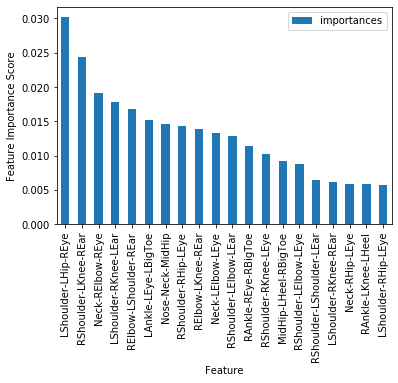

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

features[:20].plot(kind='bar', x='columns')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')

#### Training whith principal components

In [3]:
print(features['columns'][:10].values)

['LShoulder-LHip-REye' 'RShoulder-LKnee-REar' 'Neck-RElbow-REye'
 'LShoulder-RKnee-LEar' 'RElbow-LShoulder-REar' 'LAnkle-LEye-LBigToe'
 'Nose-Neck-MidHip' 'RShoulder-RHip-LEye' 'RElbow-LKnee-REar'
 'Neck-LElbow-LEye']


In [7]:
classifier = pickle.load(open('classifier_simple', 'rb'))

In [7]:
import xgboost as xgb

# hoc_X, hoc_y =df_train[features['columns'][:100].values], df_train.iloc[:,-1]
hoc_X, hoc_y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
eval_metric = ["auc","error"]
classifier = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0.1)

%time classifier.fit(hoc_X, hoc_y, eval_metric=eval_metric, verbose=True)

Wall time: 1h 41min 32s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=1, silent=False, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

##### Visualização

In [8]:
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="Blues", 
                cbar_kws={'label': 'Correct predicted samples', 'orientation': 'horizontal'})
    plt.savefig("Confusion Matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("Confusion Matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

#### Results

[0.5        0.89473684 0.90243902 0.86842105 0.60869565 0.91891892
 0.8974359  0.88      ]
              precision    recall  f1-score   support

         1.0     0.9286    0.5000    0.6500        26
         2.0     0.6071    0.8947    0.7234        19
         3.0     0.8810    0.9024    0.8916        41
         4.0     0.8049    0.8684    0.8354        38
         5.0     0.9333    0.6087    0.7368        23
         6.0     0.8718    0.9189    0.8947        37
         7.0     0.8537    0.8974    0.8750        39
         8.0     0.7857    0.8800    0.8302        25

    accuracy                         0.8266       248
   macro avg     0.8333    0.8088    0.8046       248
weighted avg     0.8429    0.8266    0.8221       248



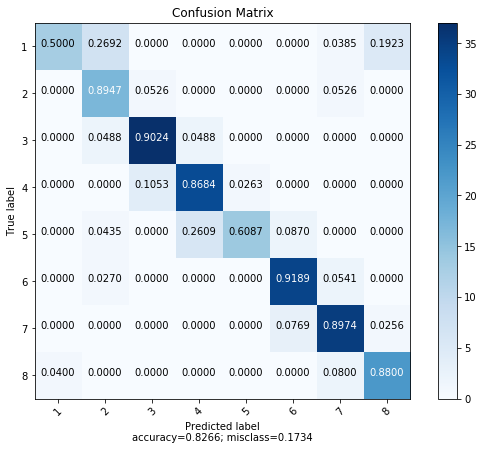

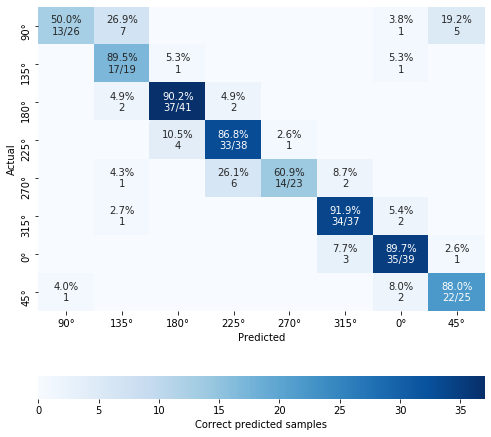

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
classes = ['90°','135°','180°','225°','270°','315°','0°','45°']

hoc_test_X, hoc_test_y = df_test.iloc[:,:-1], df_test.iloc[:,-1]
hoc_pred_y = classifier.predict(hoc_test_X)

matrix = confusion_matrix(hoc_test_y, hoc_pred_y)
print(matrix.diagonal()/matrix.sum(axis=1))

print(classification_report(hoc_test_y, hoc_pred_y, digits=4))
report = 'Results for {} \n'.format('metric')
report += classification_report(hoc_test_y, hoc_pred_y, digits=4)
report += '\n \n'

plot_confusion_matrix(cm           = confusion_matrix(hoc_test_y, hoc_pred_y),
                      normalize    = True,
                      target_names = [1,2,3,4,5,6,7,8],
                      title        = 'Confusion Matrix')

cm_analysis(hoc_test_y, hoc_pred_y, classes)

KeyboardInterrupt: 

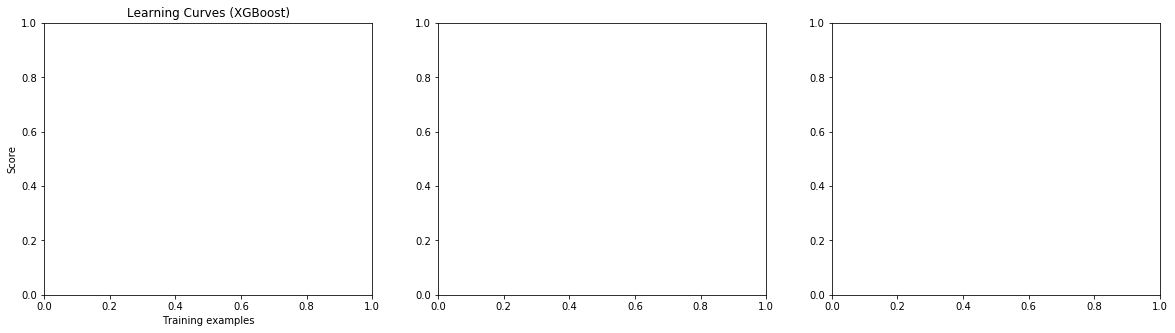

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


X, y = load_digits(return_X_y=True)

classifier = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0.1)

title = r"Learning Curves (XGBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(classifier, title, X, y, cv=cv, n_jobs=-1)
plt.show()